# Pass network individual from Whoscored

Read the blogpost: https://www.dzialowski.eu/football-data-visualisations/

## Getting the match data from Whoscored

In [12]:
import json
import re
import pandas as pd

In [13]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [14]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

In [15]:
match_html_path = 'games/Leeds 1-0 Norwich - Championship 2023_2024 Live.html'
json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

## Preparing the data

In [16]:
players_df.head()

#df = pd.DataFrame(events_dict)
#list(df.columns)

,playerId,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId
0,380580,1,Illan Meslier,GK,197,74,23,True,False,home,"{'totalSaves': {'37': 1.0}, 'collected': {'37'...",NaN,NaN,NaN,NaN,NaN,NaN,19
1,429922,22,Archie Gray,DR,0,0,17,True,False,home,"{'possession': {'6': 2.0, '10': 2.0, '13': 1.0...",118303.0,"{'value': 15, 'displayName': 'PreGame'}",98.0,NaN,NaN,NaN,19
2,302312,14,Joe Rodon,DC,193,88,26,True,True,home,"{'possession': {'1': 1.0, '2': 2.0, '5': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,19
3,322418,4,Ethan Ampadu,DC,182,78,23,True,False,home,"{'possession': {'1': 4.0, '2': 1.0, '5': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,19
4,351252,3,Junior Firpo,DL,184,78,27,True,False,home,"{'possession': {'0': 1.0, '1': 2.0, '2': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,19


In [17]:
home_team_id = list(teams_dict.keys())[0]
away_team_id = list(teams_dict.keys())[1]

choose_player = "Glen Kamara"

player_to_id = players_df.loc[players_df['name'] == choose_player, 'playerId'].iloc[0]
player_to_tid = players_df.loc[players_df['name'] == choose_player, 'teamId'].iloc[0]
[player_to_id, player_to_tid]

df = pd.DataFrame(events_dict)
df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

df = df.loc[df['eventType'] == 'TakeOn']

df.blockedX.unique()
df.head()

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,...,relatedEventId,relatedPlayerId,goalMouthZ,goalMouthY,isShot,isGoal,blockedX,blockedY,cardType,eventType
34,2.638872e+09,22,1,12.0,168,75.4,75.2,1,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 3, 'displayName': 'TakeOn'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TakeOn
35,2.638872e+09,23,1,13.0,168,79.8,73.6,1,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 3, 'displayName': 'TakeOn'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TakeOn
92,2.638873e+09,55,4,37.0,168,37.8,23.8,4,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 3, 'displayName': 'TakeOn'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TakeOn
115,2.638874e+09,67,6,14.0,19,65.6,28.8,6,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 3, 'displayName': 'TakeOn'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TakeOn
116,2.638874e+09,68,6,15.0,19,87.7,34.4,6,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 3, 'displayName': 'TakeOn'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TakeOn


### Passes dataframe

In [18]:
df = pd.DataFrame(events_dict)
df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

# create receiver column based on the next event
# this will be correct only for successfull passes
#df["receiver"] = df["playerId"].shift(-1)

# filter only passes
pass_ids = df.index[df['eventType'] == 'Pass']
team_ids = df.index[df['teamId'] == player_to_tid]
player_ids = df.index[df['playerId'] == player_to_id]

#player_ids = df.index[df['playerId'] == 107491]
#df_passes = df.loc[passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "eventType", "outcomeType"]]

df_passes = df.loc[
    pass_ids & team_ids & player_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "eventType", "outcomeType"]]

mask_complete = df_passes['outcomeType'] == "Successful"
df_passes.head()
#player_to_id.head()
#df_takeons.endX.unique()
#df.head()
#list(df.columns)

C:\Users\Habab\AppData\Local\Temp\ipykernel_22768\3626406650.py:18: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  pass_ids & team_ids & player_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "eventType", "outcomeType"]]


,id,x,y,endX,endY,teamId,playerId,eventType,outcomeType
19,2.638872e+09,57.6,60.5,57.3,72.6,19,255618.0,Pass,Successful
66,2.638873e+09,55.4,83.9,60.9,87.0,19,255618.0,Pass,Unsuccessful
109,2.638874e+09,59.6,63.0,56.3,43.7,19,255618.0,Pass,Successful
206,2.638876e+09,52.7,89.7,59.3,94.2,19,255618.0,Pass,Successful
225,2.638877e+09,40.0,88.4,53.2,95.6,19,255618.0,Pass,Successful


## Visualisation

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from mplsoccer import Pitch, FontManager
from mplsoccer import Pitch
import matplotlib.pyplot as plt

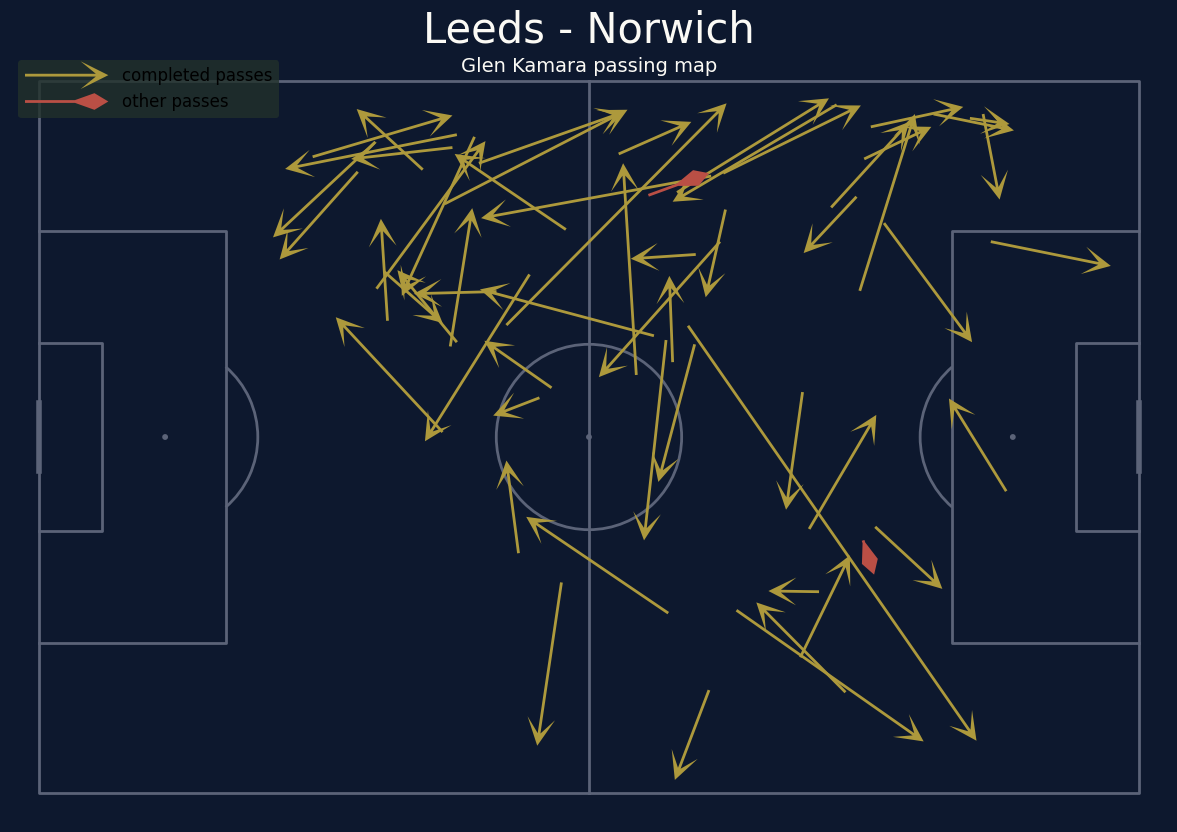

In [20]:
# Set up the pitch
#pitch = Pitch(pitch_type='whoscored', pitch_color='#22312b', line_color='#c7d5cc')

pitch = Pitch(pitch_type='opta', pitch_color='#0D182E', line_color='#5B6378')
fig, ax = pitch.draw(figsize=(15, 8), constrained_layout=True, tight_layout=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.tight_layout()
fig.set_facecolor("#0D182E")

# Plot the completed passes
pitch.arrows(df_passes[mask_complete].x, df_passes[mask_complete].y,
             df_passes[mask_complete].endX, df_passes[mask_complete].endY, width=2,
             headwidth=10, headlength=10, color='#ad993c', ax=ax, label='completed passes')

# Plot the other passes
pitch.arrows(df_passes[~mask_complete].x, df_passes[~mask_complete].y,
             df_passes[~mask_complete].endX, df_passes[~mask_complete].endY, width=2,
             headwidth=6, headlength=5, headaxislength=12,
             color='#ba4f45', ax=ax, label='other passes')

# Set up the legend
ax.legend(facecolor='#22312b', handlelength=5, edgecolor='None', fontsize=12, loc='upper left')

main_color = '#FBFAF5'

# Set the title
ax_title = ax.set_title(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", fontsize=30, color=main_color)
subtitle = choose_player + " passing map"
plt.text(50, 102, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14)

plt.savefig('outputs/pass_ind.png', bbox_inches='tight')
plt.show()